# Prophet

In [1]:
# !pip install tensorflow
# !pip install tensorflow_hub
# !pip install fbprophet

In [2]:
from fbprophet import Prophet

In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import random
import tensorflow as tf
from sklearn.metrics import mean_squared_error
import eli5
from eli5.sklearn import PermutationImportance
import seaborn as sns
import matplotlib.pyplot as plt
import os
import shap
import eli5
from eli5.sklearn import PermutationImportance

pd.options.display.max_columns = 100

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning:

The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.

Using TensorFlow backend.


In [4]:
print(tf.__version__)

2.0.0


In [5]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [6]:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

In [7]:
train_raw.head()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN


In [8]:
test_raw.head()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,1007.2,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,1007.6,0.0,0.0,0.1,1006.0,23.2,999.5,91.4,17.5,19.2,1007.6,0.0,194.7,0.0,84.0,59.9,0.0
1,4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,1007.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,1007.5,0.0,0.0,0.3,1005.9,23.1,999.4,91.6,17.4,19.1,1007.5,0.0,173.1,0.0,84.0,60.5,0.0
2,4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,1007.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,1007.4,0.0,0.0,0.7,1005.9,23.1,999.3,92.0,17.2,19.0,1007.5,0.0,208.6,0.0,85.0,60.8,0.0
3,4755,18.7,987.4,2.3,0.8,0.0,1006.6,987.6,21.1,1007.4,1007.2,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,1007.4,0.0,0.0,0.6,1005.8,22.8,999.3,93.0,17.2,18.8,1007.4,0.0,185.0,0.0,85.8,61.2,0.0
4,4756,18.4,987.4,1.1,0.7,0.0,1006.7,987.7,20.9,1007.5,1007.2,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,1007.3,0.0,0.0,0.7,1005.9,22.8,999.2,92.3,17.4,18.9,1007.5,0.0,162.8,0.0,87.3,61.7,0.0


# 1. Data Cleasing & Pre-Processing

### Time Stamp 변수 생성

In [9]:
import datetime
set_point = 1561924800000
ten_min = 600000
train_raw['timestamp_int'] = train_raw['id']*ten_min + set_point
train_raw['timestamp'] = train_raw['timestamp_int'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e3))
train_raw.drop('timestamp_int', axis=1, inplace=True)
train_raw.head()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,Y00,Y01,Y02,Y03,Y04,Y05,Y06,Y07,Y08,Y09,Y10,Y11,Y12,Y13,Y14,Y15,Y16,Y17,Y18,timestamp
0,0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,0.0,101.1,0.0,56.1,0.3,0.0,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0,12.5,11.5,11.0,20.0,20.0,10.5,10.0,10.5,10.0,7.0,7.5,7.0,9.0,10.0,9.5,9.0,8.0,9.0,NaN,2019-07-01 05:00:00
1,1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,0.0,165.3,0.0,0.0,0.4,0.0,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0,12.5,11.0,11.0,20.0,20.0,10.0,9.5,10.0,9.5,6.5,7.5,7.0,8.5,10.0,9.5,9.0,7.5,9.0,NaN,2019-07-01 05:10:00
2,2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,0.0,144.0,0.0,0.0,0.6,0.0,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0,12.0,11.0,11.0,19.5,19.5,10.0,9.0,10.0,9.0,6.5,7.5,6.5,8.0,9.5,9.5,8.5,7.5,8.5,NaN,2019-07-01 05:20:00
3,3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,0.0,115.9,0.0,294.1,0.1,0.0,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0,12.0,11.0,11.0,19.5,19.5,9.5,9.0,9.5,9.0,6.0,7.0,6.0,8.0,9.5,9.0,8.5,7.5,8.5,NaN,2019-07-01 05:30:00
4,4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,0.0,124.7,0.0,0.0,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0,12.0,10.5,10.5,19.0,19.5,9.5,8.5,9.5,8.5,6.0,7.0,6.0,7.5,9.5,9.0,8.5,7.5,8.5,NaN,2019-07-01 05:40:00


In [10]:
set_point = 1561924800000
ten_min = 600000
test_raw['timestamp_int'] = test_raw['id']*ten_min + set_point
test_raw['timestamp'] = test_raw['timestamp_int'].apply(lambda x: datetime.datetime.fromtimestamp(x/1e3))
test_raw.drop('timestamp_int', axis=1, inplace=True)
test_raw.head()

,id,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,timestamp
0,4752,18.7,987.4,1.5,1.3,0.0,1006.8,987.7,21.1,1007.5,1007.2,0.0,0.0,96.1,333.6,0.0,199.6,0.0,36.0,1.1,0.0,94.7,0.0,1000.3,1007.6,0.0,0.0,0.1,1006.0,23.2,999.5,91.4,17.5,19.2,1007.6,0.0,194.7,0.0,84.0,59.9,0.0,2019-08-03 05:00:00
1,4753,18.8,987.4,1.1,1.2,0.0,1006.7,987.7,21.2,1007.5,1007.2,0.0,0.0,96.2,335.5,0.0,194.0,0.0,127.7,0.6,0.0,95.3,0.0,1000.2,1007.5,0.0,0.0,0.3,1005.9,23.1,999.4,91.6,17.4,19.1,1007.5,0.0,173.1,0.0,84.0,60.5,0.0,2019-08-03 05:10:00
2,4754,19.0,987.4,1.3,1.2,0.0,1006.6,987.6,21.2,1007.4,1007.2,0.0,0.0,96.4,0.0,0.0,172.9,0.0,59.0,0.0,0.0,93.9,0.0,1000.1,1007.4,0.0,0.0,0.7,1005.9,23.1,999.3,92.0,17.2,19.0,1007.5,0.0,208.6,0.0,85.0,60.8,0.0,2019-08-03 05:20:00
3,4755,18.7,987.4,2.3,0.8,0.0,1006.6,987.6,21.1,1007.4,1007.2,0.0,0.0,96.5,252.9,0.0,153.5,0.0,54.9,0.4,0.0,94.4,0.0,1000.1,1007.4,0.0,0.0,0.6,1005.8,22.8,999.3,93.0,17.2,18.8,1007.4,0.0,185.0,0.0,85.8,61.2,0.0,2019-08-03 05:30:00
4,4756,18.4,987.4,1.1,0.7,0.0,1006.7,987.7,20.9,1007.5,1007.2,0.0,0.0,96.6,238.2,0.0,173.8,0.0,48.8,0.8,0.0,95.7,0.0,1000.2,1007.3,0.0,0.0,0.7,1005.9,22.8,999.2,92.3,17.4,18.9,1007.5,0.0,162.8,0.0,87.3,61.7,0.0,2019-08-03 05:40:00


In [11]:
# 모든 값이 동일한 column 제거
train = train_raw.loc[:, train_raw.max() != train_raw.min()]
test = test_raw.loc[:, test_raw.max() != test_raw.min()]
test.drop(['id', 'timestamp'], axis=1, inplace=True)

C:\Users\weroo\Anaconda\Anaconda3\lib\site-packages\pandas\core\frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [12]:
# 기상청 데이터만 추출
X_train = train.loc[:, 'X00':'X39']
X_train.head()

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,9.7,988.8,1.2,0.6,0.0,1009.3,989.6,12.2,1009.9,1009.8,0.0,0.0,82.4,71.3,101.1,56.1,0.3,91.0,0.0,1002.5,1009.8,1.1,2.3,0.5,1008.7,12.3,1001.6,69.1,8.2,10.7,1010.1,0.0,256.4,0.0,77.2,62.6,0.0
1,9.3,988.9,1.7,1.9,0.0,1009.3,989.6,12.1,1010.0,1009.9,0.0,0.0,81.2,121.8,165.3,0.0,0.4,91.9,0.0,1002.5,1009.9,0.0,0.0,0.0,1008.7,12.1,1001.7,70.3,8.3,10.3,1010.1,0.0,215.4,0.0,77.3,63.5,0.0
2,9.4,989.0,1.1,2.3,0.0,1009.2,989.7,12.1,1010.1,1010.1,0.0,0.0,86.1,232.0,144.0,0.0,0.6,93.3,0.0,1002.4,1009.8,0.0,0.0,0.0,1008.6,12.1,1001.6,71.5,8.0,9.7,1010.0,0.0,235.2,0.0,77.3,63.9,0.0
3,9.4,988.9,1.5,0.7,0.0,1009.2,989.6,12.0,1010.0,1010.0,0.0,0.0,87.7,0.0,115.9,294.1,0.1,93.4,0.0,1002.4,1009.7,0.0,0.0,0.2,1008.7,12.1,1001.5,73.2,7.7,9.4,1010.1,0.0,214.0,0.0,77.5,64.5,0.0
4,9.2,988.9,0.8,1.7,0.0,1009.2,989.7,12.0,1010.1,1010.0,0.0,0.0,88.9,0.0,124.7,0.0,0.0,94.1,0.0,1002.4,1009.7,0.0,0.0,0.0,1008.7,12.0,1001.5,74.3,7.4,9.4,1010.1,0.0,174.9,0.0,78.0,65.0,0.0


In [13]:
#표준화 함수 생성
def standardization(df):
    mean = np.mean(df)
    std = np.std(df)
    norm = (df - mean) / (std - 1e-07)
    return norm, mean, std


# 학습데이터 표준화
X_train, mean, std = standardization(X_train)

# train set에서 도출된 평균과 표준편차로 테스트데이터 표준화
test = (test - mean) / (std - 1e-07)

In [14]:
X_train

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,-2.236613,0.053249,-0.289028,-0.911441,-0.286772,0.284592,0.174800,-2.160980,0.315249,0.396477,-0.302862,-1.012516,0.637025,-0.911726,-0.749131,-0.911954,-0.932947,0.894310,-0.279106,0.215838,0.277710,0.105335,-1.044134,-0.701087,0.332281,-2.314698,0.232479,0.159935,-2.110001,-1.766809,0.298012,-1.015988,0.482067,-0.274975,0.577780,0.240728,-0.234601
1,-2.321591,0.083015,0.177501,0.477370,-0.286772,0.284592,0.174800,-2.183828,0.343658,0.424679,-0.302862,-1.012516,0.583154,-0.400474,-0.092525,-1.395861,-0.846359,0.935541,-0.279106,0.215838,0.306973,-0.902731,-1.061634,-1.104062,0.332281,-2.362038,0.261979,0.215689,-2.091884,-1.842695,0.298012,-1.015988,0.070297,-0.274975,0.582902,0.289731,-0.234601
2,-2.300347,0.112780,-0.382334,0.904697,-0.286772,0.255134,0.204183,-2.183828,0.372068,0.481084,-0.302862,-1.012516,0.803125,0.715170,-0.310371,-1.395861,-0.673184,0.999678,-0.279106,0.186142,0.277710,-0.902731,-1.061634,-1.104062,0.303262,-2.362038,0.232479,0.271442,-2.146235,-1.956524,0.268945,-1.015988,0.269152,-0.274975,0.582902,0.311510,-0.234601
3,-2.300347,0.083015,-0.009111,-0.804610,-0.286772,0.255134,0.174800,-2.206676,0.343658,0.452881,-0.302862,-1.012516,0.874952,-1.633554,-0.597764,1.140988,-1.106121,1.004260,-0.279106,0.186142,0.248447,-0.902731,-1.061634,-0.942872,0.332281,-2.362038,0.202979,0.350426,-2.200586,-2.013438,0.298012,-1.015988,0.056237,-0.274975,0.593145,0.344178,-0.234601
4,-2.342836,0.083015,-0.662251,0.263707,-0.286772,0.255134,0.204183,-2.206676,0.372068,0.452881,-0.302862,-1.012516,0.928822,-1.633554,-0.507762,-1.395861,-1.192709,1.036328,-0.279106,0.186142,0.248447,-0.902731,-1.061634,-1.104062,0.332281,-2.385708,0.202979,0.401533,-2.254937,-2.013438,0.298012,-1.015988,-0.336452,-0.274975,0.618753,0.371402,-0.234601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4747,-0.069662,-0.303940,-0.568945,-0.697778,-0.286772,-0.422397,-0.383472,0.009578,-0.366580,-0.280379,0.449229,1.183872,1.216131,1.738687,1.028410,0.980548,-0.413422,0.834754,2.295301,-0.407792,-0.395341,-0.902731,-1.061634,-0.136920,-0.451211,0.407351,-0.416518,1.126324,-0.388886,-0.173206,-0.457735,0.930342,0.102435,-0.274975,0.838982,0.022938,-0.126302
4748,-0.069662,-0.303940,-0.942168,-0.804610,-0.286772,-0.451855,-0.383472,-0.013270,-0.366580,-0.280379,0.449229,1.183872,1.229598,0.557238,1.052956,0.734713,-0.326835,0.853079,2.295301,-0.437489,-0.395341,-0.902731,-1.061634,-0.056325,-0.451211,0.360011,-0.416518,1.191369,-0.388886,-0.154235,-0.457735,0.930342,-0.469021,-0.274975,0.849226,0.050162,-0.126302
4749,-0.112151,-0.274175,-0.568945,-0.911441,-0.286772,-0.422397,-0.412855,-0.058966,-0.394989,-0.252177,0.449229,1.183872,1.243066,-0.339731,0.836133,1.184117,-0.673184,0.885147,2.295301,-0.407792,-0.366078,-0.902731,-1.061634,-0.942872,-0.451211,0.360011,-0.387018,1.140262,-0.370769,-0.154235,-0.457735,0.930342,0.459972,-0.274975,0.874834,0.039273,-0.126302
4750,-0.175885,-0.274175,-0.568945,-0.697778,-0.286772,-0.422397,-0.354090,-0.081814,-0.338170,-0.252177,0.449229,1.183872,1.243066,1.644535,0.825906,-1.395861,-0.673184,0.917216,2.295301,-0.407792,-0.366078,-0.902731,-1.061634,-1.023467,-0.451211,0.289001,-0.387018,1.135616,-0.388886,-0.135263,-0.428667,0.930342,0.919950,-0.274975,0.885077,0.088275,-0.126302


In [15]:
test

,X00,X01,X02,X03,X04,X05,X06,X07,X08,X09,X10,X11,X12,X13,X15,X17,X18,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39
0,-0.324597,-0.363472,-0.009111,-0.163620,-0.286772,-0.451855,-0.383472,-0.127510,-0.366580,-0.336784,-0.302862,-1.012516,1.252044,1.743749,0.258279,-1.085332,-0.240247,1.063816,-0.279106,-0.437489,-0.366078,-0.902731,-1.061634,-1.023467,-0.451211,0.265331,-0.387018,1.196016,-0.425120,-0.154235,-0.428667,-1.015988,-0.137597,-0.274975,0.926050,0.093720,-0.234601
1,-0.303353,-0.363472,-0.382334,-0.270451,-0.286772,-0.481312,-0.383472,-0.104662,-0.366580,-0.336784,-0.302862,-1.012516,1.256533,1.762984,0.201005,-0.294346,-0.673184,1.091303,-0.279106,-0.467185,-0.395341,-0.902731,-1.061634,-0.862277,-0.480229,0.241661,-0.416518,1.205308,-0.443237,-0.173206,-0.457735,-1.015988,-0.354529,-0.274975,0.926050,0.126389,-0.234601
2,-0.260864,-0.363472,-0.195722,-0.270451,-0.286772,-0.510770,-0.412855,-0.104662,-0.394989,-0.336784,-0.302862,-1.012516,1.265512,-1.633554,-0.014796,-0.886939,-1.192709,1.027166,-0.279106,-0.496882,-0.424604,-0.902731,-1.061634,-0.539896,-0.480229,0.241661,-0.446017,1.223892,-0.479471,-0.192178,-0.457735,-1.015988,0.002004,-0.274975,0.977266,0.142723,-0.234601
3,-0.324597,-0.363472,0.737335,-0.697778,-0.286772,-0.510770,-0.412855,-0.127510,-0.394989,-0.336784,-0.302862,-1.012516,1.270001,0.926757,-0.213209,-0.922305,-0.846359,1.050072,-0.279106,-0.496882,-0.424604,-0.902731,-1.061634,-0.620491,-0.509248,0.170651,-0.446017,1.270353,-0.479471,-0.230121,-0.486802,-1.015988,-0.235015,-0.274975,1.018239,0.164502,-0.234601
4,-0.388331,-0.363472,-0.382334,-0.804610,-0.286772,-0.481312,-0.383472,-0.173206,-0.366580,-0.336784,-0.302862,-1.012516,1.274490,0.777937,-0.005591,-0.974922,-0.500009,1.109628,-0.279106,-0.467185,-0.453867,-0.902731,-1.061634,-0.539896,-0.480229,0.170651,-0.475517,1.237830,-0.443237,-0.211149,-0.457735,-1.015988,-0.457974,-0.274975,1.095063,0.191725,-0.234601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11515,1.162526,1.362943,2.230228,2.507172,-0.286772,0.991581,1.408876,1.060584,1.281173,1.186142,-0.302862,0.560274,0.892909,-0.969432,-0.744017,0.128319,0.365865,0.266680,-0.279106,1.017649,1.184866,0.563546,0.230365,2.522721,1.144790,1.330481,1.205973,0.508393,0.680016,0.832281,1.140960,0.701982,-0.389680,-0.274975,0.705821,0.507520,-0.126302
11516,1.141281,1.362943,1.390476,1.652519,-0.286772,0.991581,1.408876,1.060584,1.281173,1.186142,-0.302862,0.560274,0.327270,-1.108128,-0.915839,0.224065,1.318326,0.303330,-0.279106,1.017649,1.184866,0.838473,-0.004751,2.683911,1.115772,1.306811,1.205973,0.513039,0.988005,0.832281,1.111893,0.701982,-0.326408,-0.274975,0.700699,0.529299,-0.126302
11517,1.141281,1.362943,2.136922,1.118360,-0.286772,1.050496,1.379494,1.037737,1.252763,1.214344,-0.302862,0.560274,0.417054,-1.339963,-0.714357,0.198188,1.318326,0.339980,-0.279106,1.077042,1.214129,1.205042,0.054598,2.764506,1.115772,1.283141,1.235473,0.531623,0.915537,0.813310,1.111893,0.701982,-0.037165,-0.274975,0.680212,0.551078,-0.126302
11518,1.120037,1.362943,0.830641,1.438855,-0.286772,1.021039,1.379494,1.014889,1.252763,1.186142,-0.302862,0.560274,0.264421,-1.329839,-0.729699,0.224065,1.751263,0.376630,-0.279106,1.047345,1.214129,0.655189,0.053077,1.716769,1.115772,1.235801,1.235473,0.540916,0.988005,0.794338,1.111893,0.701982,-0.343482,-0.274975,0.726307,0.578302,-0.126302


In [16]:
prophet_train_Y16 = train_raw.loc[:, ['timestamp', 'Y16']]
prophet_train_Y16 = prophet_train_Y16[prophet_train_Y16.Y16.notnull()]
prophet_train_Y16

,timestamp,Y16
0,2019-07-01 05:00:00,8.0
1,2019-07-01 05:10:00,7.5
2,2019-07-01 05:20:00,7.5
3,2019-07-01 05:30:00,7.5
4,2019-07-01 05:40:00,7.5
...,...,...
4315,2019-07-31 04:10:00,20.5
4316,2019-07-31 04:20:00,20.5
4317,2019-07-31 04:30:00,20.0
4318,2019-07-31 04:40:00,20.0


In [17]:
prophet_train_Y18 = train_raw.loc[:, ['timestamp', 'Y18']]
prophet_train_Y18 = prophet_train_Y18[prophet_train_Y18.Y18.notnull()]
prophet_train_Y18

,timestamp,Y18
4320,2019-07-31 05:00:00,20.5
4321,2019-07-31 05:10:00,20.5
4322,2019-07-31 05:20:00,20.5
4323,2019-07-31 05:30:00,20.5
4324,2019-07-31 05:40:00,20.5
...,...,...
4747,2019-08-03 04:10:00,21.5
4748,2019-08-03 04:20:00,21.5
4749,2019-08-03 04:30:00,21.5
4750,2019-08-03 04:40:00,21.5


In [18]:
prophet_train_Y16.rename(columns={'Y16': 'Y18'}, inplace=True)
prophet_train = pd.concat([prophet_train_Y16, prophet_train_Y18], axis=0)
prophet_train

,timestamp,Y18
0,2019-07-01 05:00:00,8.0
1,2019-07-01 05:10:00,7.5
2,2019-07-01 05:20:00,7.5
3,2019-07-01 05:30:00,7.5
4,2019-07-01 05:40:00,7.5
...,...,...
4747,2019-08-03 04:10:00,21.5
4748,2019-08-03 04:20:00,21.5
4749,2019-08-03 04:30:00,21.5
4750,2019-08-03 04:40:00,21.5


In [19]:
prophet_train.rename(columns={'timestamp': 'ds',
                             'Y18': 'y'}, inplace=True)
prophet_train.head()

,ds,y
0,2019-07-01 05:00:00,8.0
1,2019-07-01 05:10:00,7.5
2,2019-07-01 05:20:00,7.5
3,2019-07-01 05:30:00,7.5
4,2019-07-01 05:40:00,7.5


In [20]:
prophet_train.tail()

,ds,y
4747,2019-08-03 04:10:00,21.5
4748,2019-08-03 04:20:00,21.5
4749,2019-08-03 04:30:00,21.5
4750,2019-08-03 04:40:00,21.5
4751,2019-08-03 04:50:00,21.0


In [21]:
prophet_model = Prophet(changepoint_prior_scale=0.01)
prophet_model.fit(prophet_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [22]:
# 하루는 144*10분
future_dates = prophet_model.make_future_dataframe(periods = 144*80, freq='10min')

future_dates

,ds
0,2019-07-01 05:00:00
1,2019-07-01 05:10:00
2,2019-07-01 05:20:00
3,2019-07-01 05:30:00
4,2019-07-01 05:40:00
...,...
16267,2019-10-22 04:10:00
16268,2019-10-22 04:20:00
16269,2019-10-22 04:30:00
16270,2019-10-22 04:40:00


In [23]:
forecast = prophet_model.predict(future_dates)
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-07-01 05:00:00,20.399499,8.013774,15.985239,20.399499,20.399499,-8.431690,-8.431690,-8.431690,-6.622235,-6.622235,-6.622235,-1.809456,-1.809456,-1.809456,0.0,0.0,0.0,11.967809
1,2019-07-01 05:10:00,20.405249,7.916870,15.762598,20.405249,20.405249,-8.509614,-8.509614,-8.509614,-6.701561,-6.701561,-6.701561,-1.808052,-1.808052,-1.808052,0.0,0.0,0.0,11.895635
2,2019-07-01 05:20:00,20.410998,8.063301,15.754229,20.410998,20.410998,-8.584189,-8.584189,-8.584189,-6.777771,-6.777771,-6.777771,-1.806418,-1.806418,-1.806418,0.0,0.0,0.0,11.826809
3,2019-07-01 05:30:00,20.416748,7.933068,15.867489,20.416748,20.416748,-8.657189,-8.657189,-8.657189,-6.852635,-6.852635,-6.852635,-1.804554,-1.804554,-1.804554,0.0,0.0,0.0,11.759558
4,2019-07-01 05:40:00,20.422497,7.630880,15.885782,20.422497,20.422497,-8.730393,-8.730393,-8.730393,-6.927930,-6.927930,-6.927930,-1.802463,-1.802463,-1.802463,0.0,0.0,0.0,11.692104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16267,2019-10-22 04:10:00,51.186049,-48.150166,133.601696,-39.886429,141.620554,-6.544368,-6.544368,-6.544368,-6.122581,-6.122581,-6.122581,-0.421787,-0.421787,-0.421787,0.0,0.0,0.0,44.641681
16268,2019-10-22 04:20:00,51.188213,-45.454373,134.717517,-39.893770,141.632332,-6.651406,-6.651406,-6.651406,-6.240967,-6.240967,-6.240967,-0.410439,-0.410439,-0.410439,0.0,0.0,0.0,44.536807
16269,2019-10-22 04:30:00,51.190377,-46.655924,134.306086,-39.901110,141.644110,-6.748013,-6.748013,-6.748013,-6.348865,-6.348865,-6.348865,-0.399148,-0.399148,-0.399148,0.0,0.0,0.0,44.442364
16270,2019-10-22 04:40:00,51.192541,-47.107862,134.201701,-39.908451,141.655888,-6.835365,-6.835365,-6.835365,-6.447450,-6.447450,-6.447450,-0.387914,-0.387914,-0.387914,0.0,0.0,0.0,44.357177


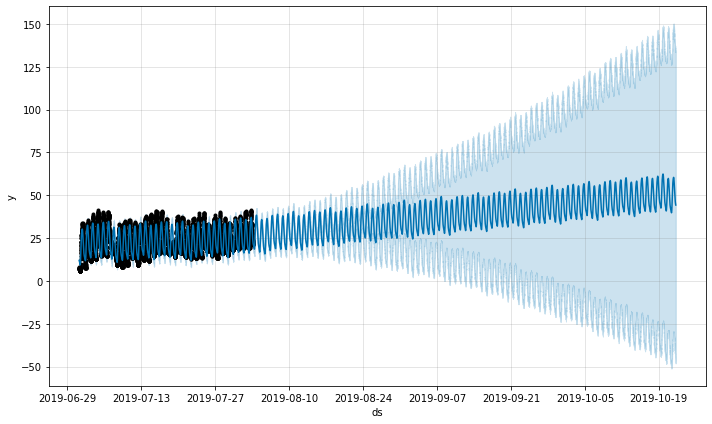

In [24]:
# Python\
fig = prophet_model.plot(forecast)

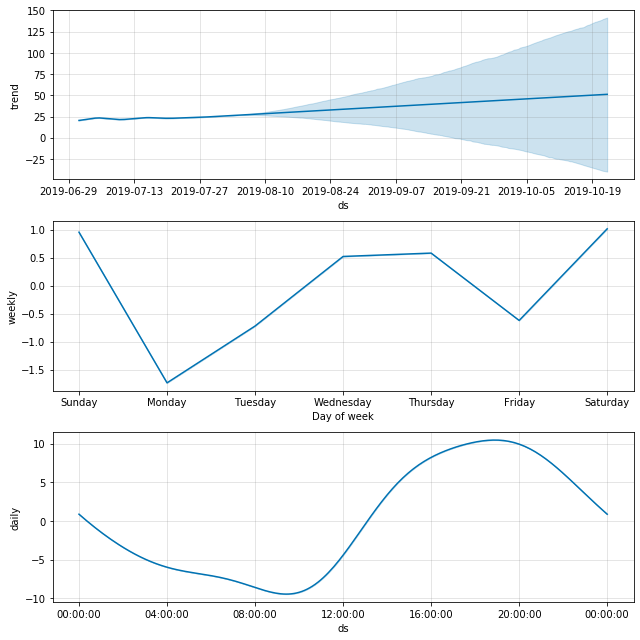

In [25]:
fig2 = prophet_model.plot_components(forecast)

In [26]:
test.shape, 

((11520, 37),)

In [27]:
sub = forecast.iloc[-test.shape[0]:]['yhat']
sub

4752     21.093484
4753     21.027868
4754     20.965146
4755     20.903542
4756     20.841277
           ...    
16267    44.641681
16268    44.536807
16269    44.442364
16270    44.357177
16271    44.279894
Name: yhat, Length: 11520, dtype: float64

In [28]:
# 제출 파일 만들기
submit = pd.DataFrame({'id':range(144*33, 144*113),
              'Y18':sub})
submit

,id,Y18
4752,4752,21.093484
4753,4753,21.027868
4754,4754,20.965146
4755,4755,20.903542
4756,4756,20.841277
...,...,...
16267,16267,44.641681
16268,16268,44.536807
16269,16269,44.442364
16270,16270,44.357177


(6.0059168181455975, -9.595104502623318, 25.69148901188895)

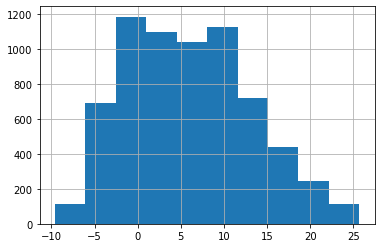

In [29]:
best_submission = pd.read_csv('LSTM_Transfer_Learning-2.6078.csv')
pred_diff = submit.Y18 - best_submission.Y18
pred_diff.hist()
pred_diff.mean(), pred_diff.min(), pred_diff.max()

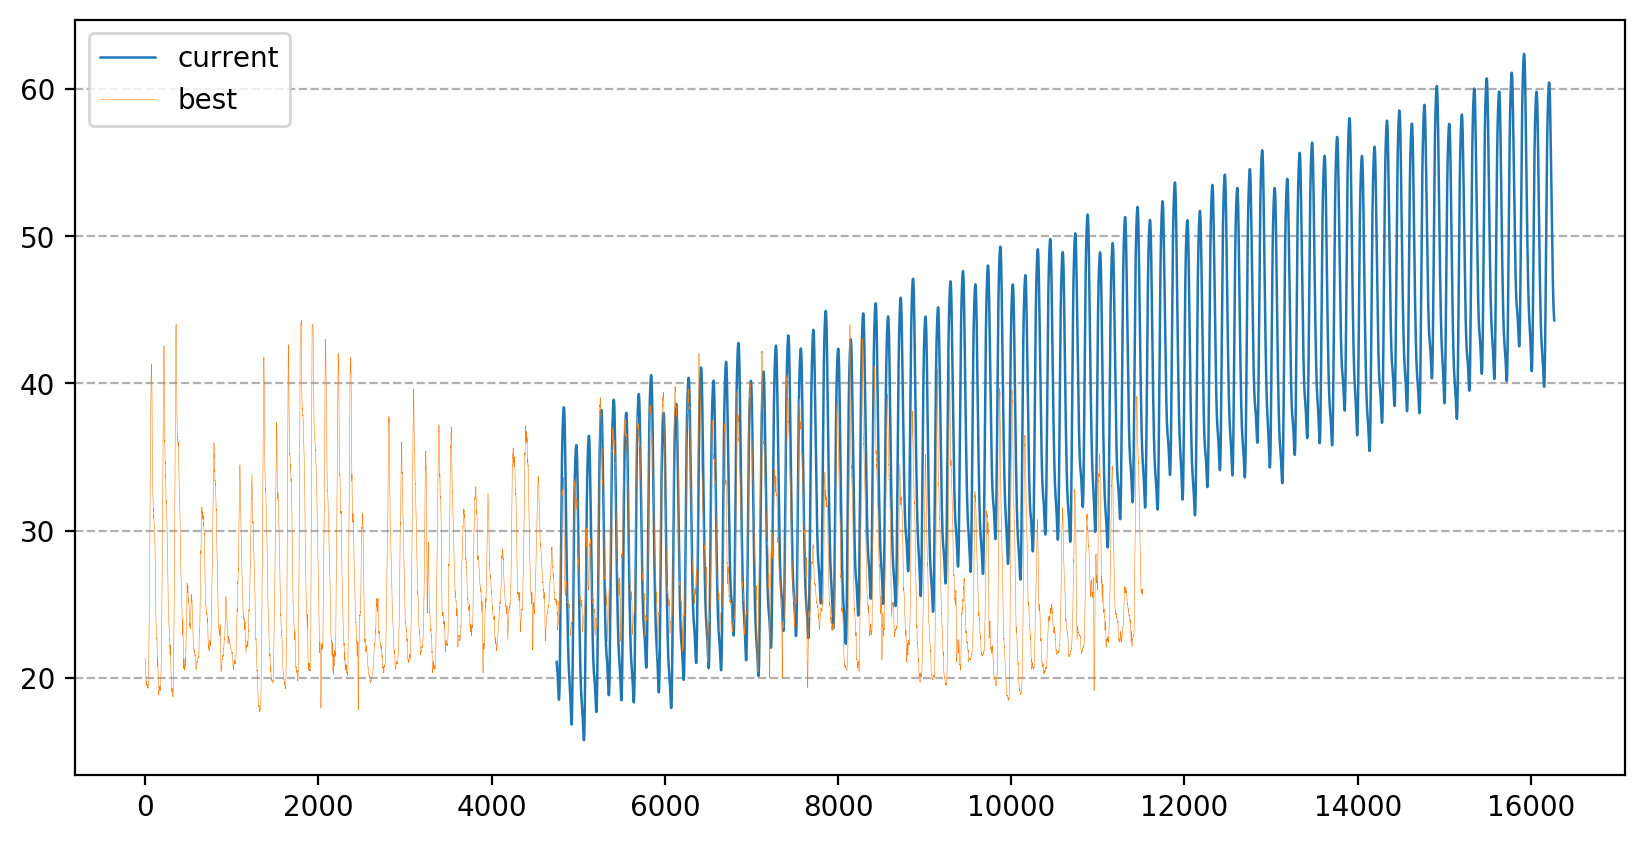

In [30]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=200, sharey=True)
ax.plot(submit.Y18, lw=0.9, label='current')
ax.plot(best_submission.Y18, lw=0.2, label='best')
ax.grid(axis='y', ls='--')
ax.legend();